In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3

cs224 
last updated: 2020-05-15 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()
# sns.set_style("whitegrid")

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

* [Corona-Hub von www.npgeo.de](https://npgeo-corona-npgeo-de.hub.arcgis.com/)
    * [RKI COVID19](https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0)
    * [CSV](https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv)
    * [Robert Koch-Institut: COVID-19-Dashboard](https://npgeo-corona-npgeo-de.hub.arcgis.com/app/478220a4c454480e823b17327b2bf1d4)
* [Priesemann-Group/covid19_inference_forecast](https://github.com/Priesemann-Group/covid19_inference_forecast/commit/4d34d342cd8e58c18b5107ce38c537d4e83bc561)
    * [data_retrieval.py](https://github.com/Priesemann-Group/covid19_inference_forecast/blob/master/covid19_inference/data_retrieval.py)

* [data source description](https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74)

* [DRP Austria Covid-19 Hub](https://covid-19-drp-austria.hub.arcgis.com/)
    * [Dashboard](https://experience.arcgis.com/experience/fb603473e1f74f0bbae48155ff238565)
    * [Daten](https://covid-19-drp-austria.hub.arcgis.com/search?categories=covid-19)
        * [COVID19 VERLAUF BUNDESLAND](https://covid-19-drp-austria.hub.arcgis.com/datasets/covid19-verlauf-bundesland?orderBy=genesene&orderByAsc=false)
    * [data.gv.at](https://www.data.gv.at/covid-19/)

In [5]:
df = covid19.get_rki_df()
cbr_germany = covid19.CasesByRegion('Germany', df=df)
cbr_germany.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-10,171324,151561,7444,288,0,9
2020-05-11,171825,151561,7510,501,0,66
2020-05-12,172289,151561,7633,464,0,123
2020-05-13,172800,151561,7732,511,0,99
2020-05-14,173073,151560,7812,273,-1,80


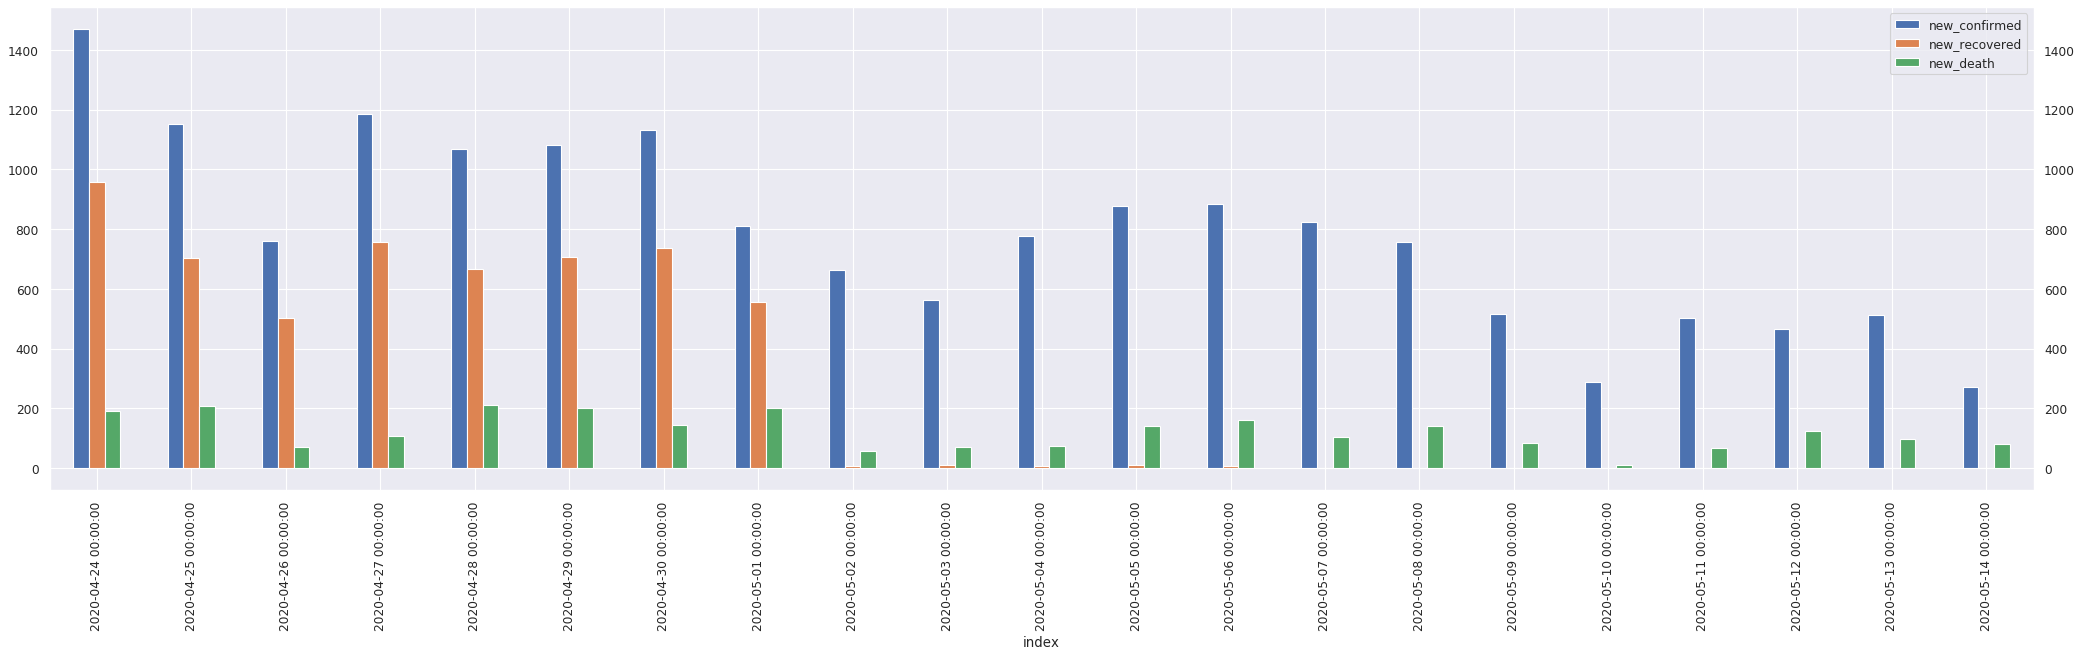

In [6]:
cbr_germany.plot_daily_stats()

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric: seor: 438.76201633497607, max asymptotic: 178938.22654402917; growth-rate: 0.003, date:2020-06-08 00:00:00, projected value: 88.8454164109209


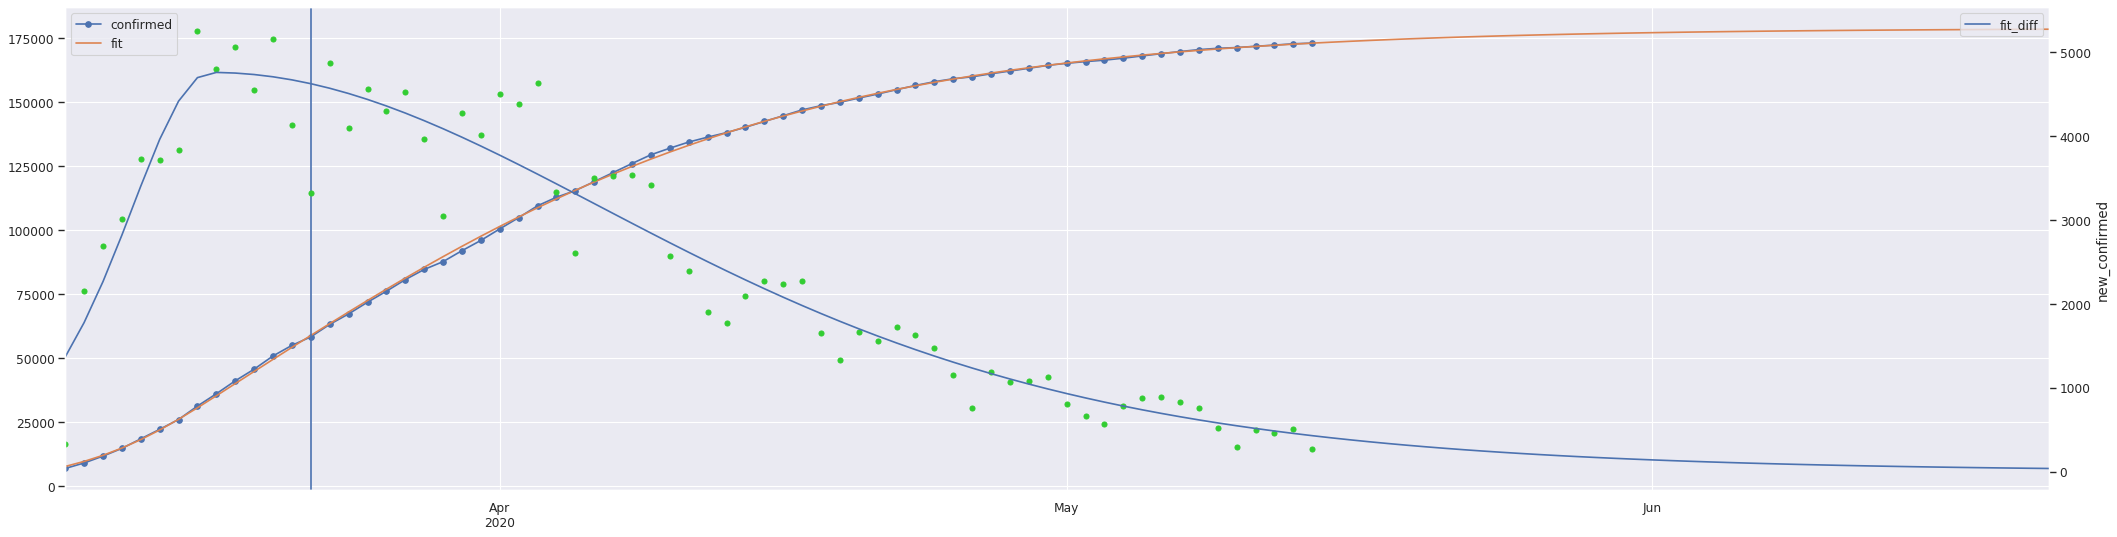

In [7]:
cbr_germany.fit(first_date=pd.to_datetime('2020-03-09'))
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [8]:
# country_name, first_date, init_add, restriction_start_date = 'Germany', pd.to_datetime('2020-03-09'), 0, datetime.datetime(2020, 3, 22)
# ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, in_df=cbr_germany.df, first_date=first_date, init_add=init_add)
# if len(lpopt) == 4:
#     steady_state_rate = lpopt[1] * lpopt[3]
# else:
#     steady_state_rate = 0.0
# print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate)
# fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
# ax = plt.subplot(1,1,1)
# ldf[['confirmed', label + '_fit']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
# ax.axvline(restriction_start_date);

# ax2 = ax.twinx()
# ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
# lbl = 'confirmed' + '_diff'
# ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')


# l = len(ax.get_yticks())
# a1 = ax.get_yticks()[0]
# e1 = ax.get_yticks()[-1]
# a2 = ax2.get_yticks()[0]
# e2 = ax2.get_yticks()[-1]
# ax.set_yticks(np.linspace(a1, e1, l));
# ax2.set_yticks(np.linspace(a2, e2, l));

In [9]:
cbr_germany.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,4760.705254


In [10]:
cbr_germany.calculate_R_estimates()
cbr_germany.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-12,0.592,0.593,0.423,0.53,0.572


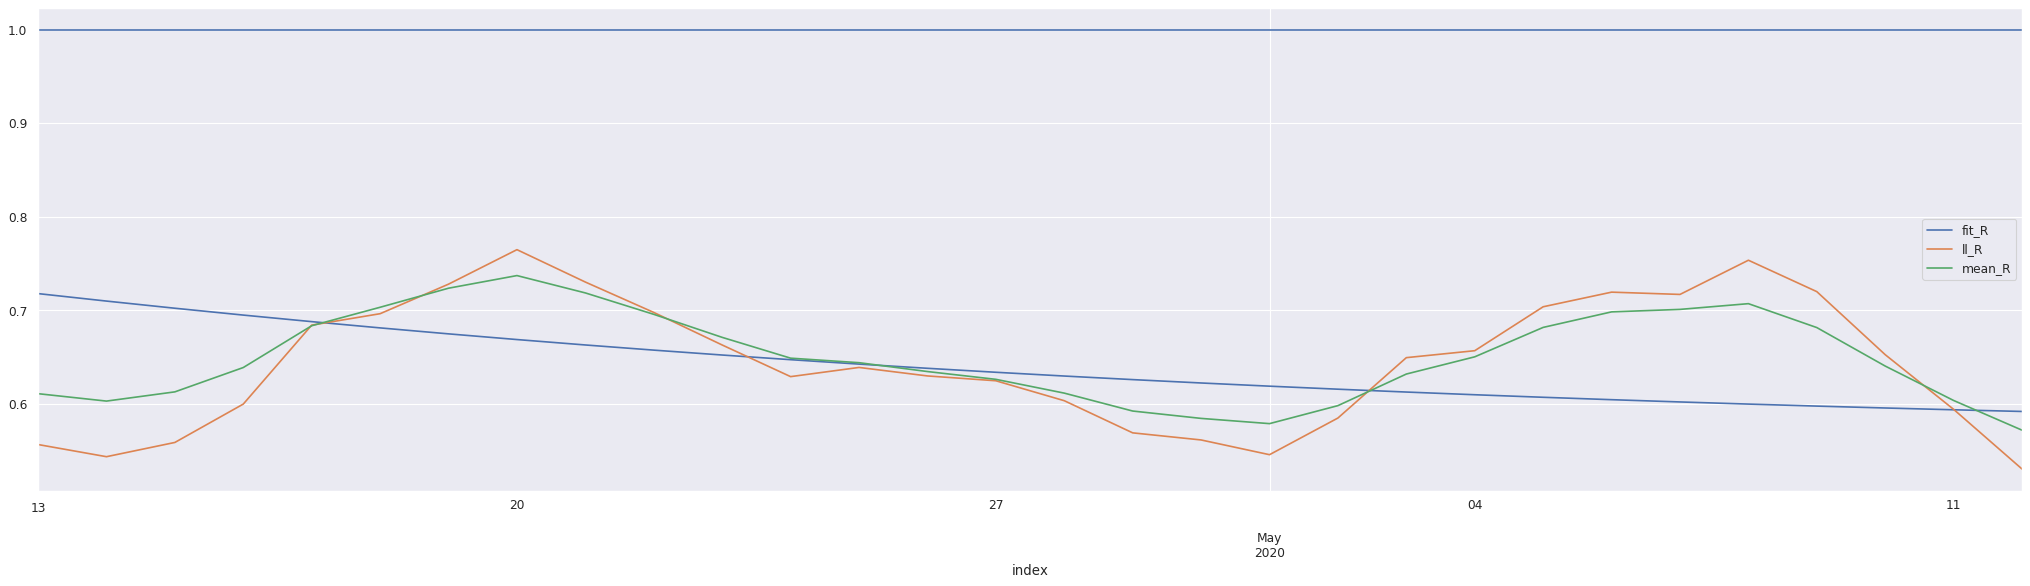

In [11]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [12]:
# --------------------------------------------------------------------------------------------------------------------------------



# --------------------------------------------------------------------------------------------------------------------------------

In [13]:
df = covid19.get_rki_df(state='Bayern')
cbr_bavaria = covid19.CasesByRegion('Bavaria', df=df)
cbr_bavaria.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-10,44708,39478,2253,59,0,1
2020-05-11,44842,39478,2254,134,0,1
2020-05-12,44974,39478,2254,132,0,0
2020-05-13,45085,39478,2256,111,0,2
2020-05-14,45135,39478,2257,50,0,1


In [14]:
einwohner_deutschland = 83019213.0
einwohner_bayern      = 13076721.0
prozent_bayern        = einwohner_bayern / einwohner_deutschland

bavaria_new_confirmed_threshold = (100.0 * prozent_bayern) // 1 + 1
bavaria_new_confirmed_threshold

16.0

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric: seor: 131.7979785820913, max asymptotic: 45930.087594532015; growth-rate: 0.002, date:2020-06-06 00:00:00, projected value: 14.51673400607902


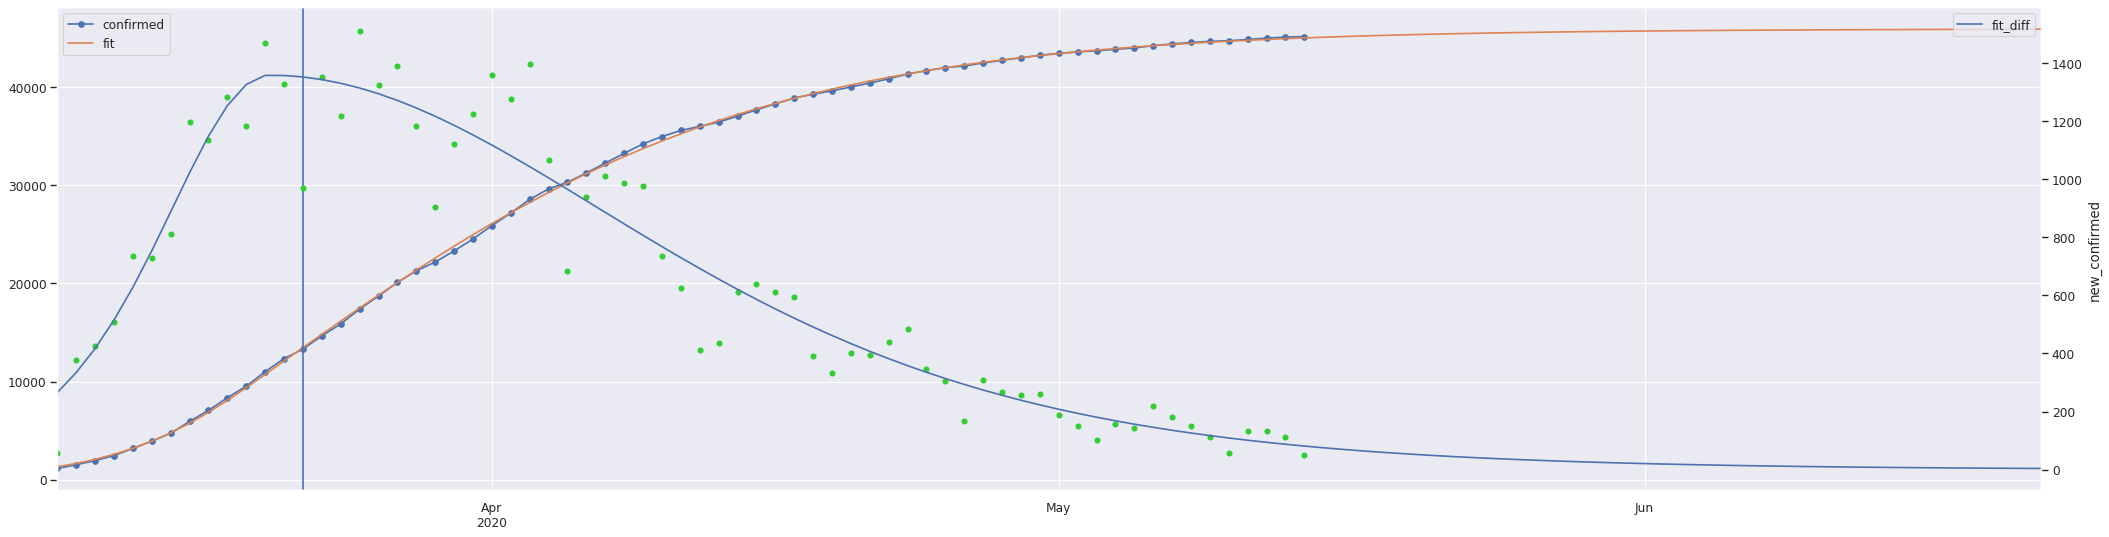

In [15]:
cbr_bavaria.fit(first_date=pd.to_datetime('2020-03-09'), new_confirmed_threshold=bavaria_new_confirmed_threshold)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_bavaria.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [16]:
cbr_bavaria.calculate_R_estimates()
cbr_bavaria.R().round(3)

,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-12,0.511,0.887,0.894,0.713,0.703


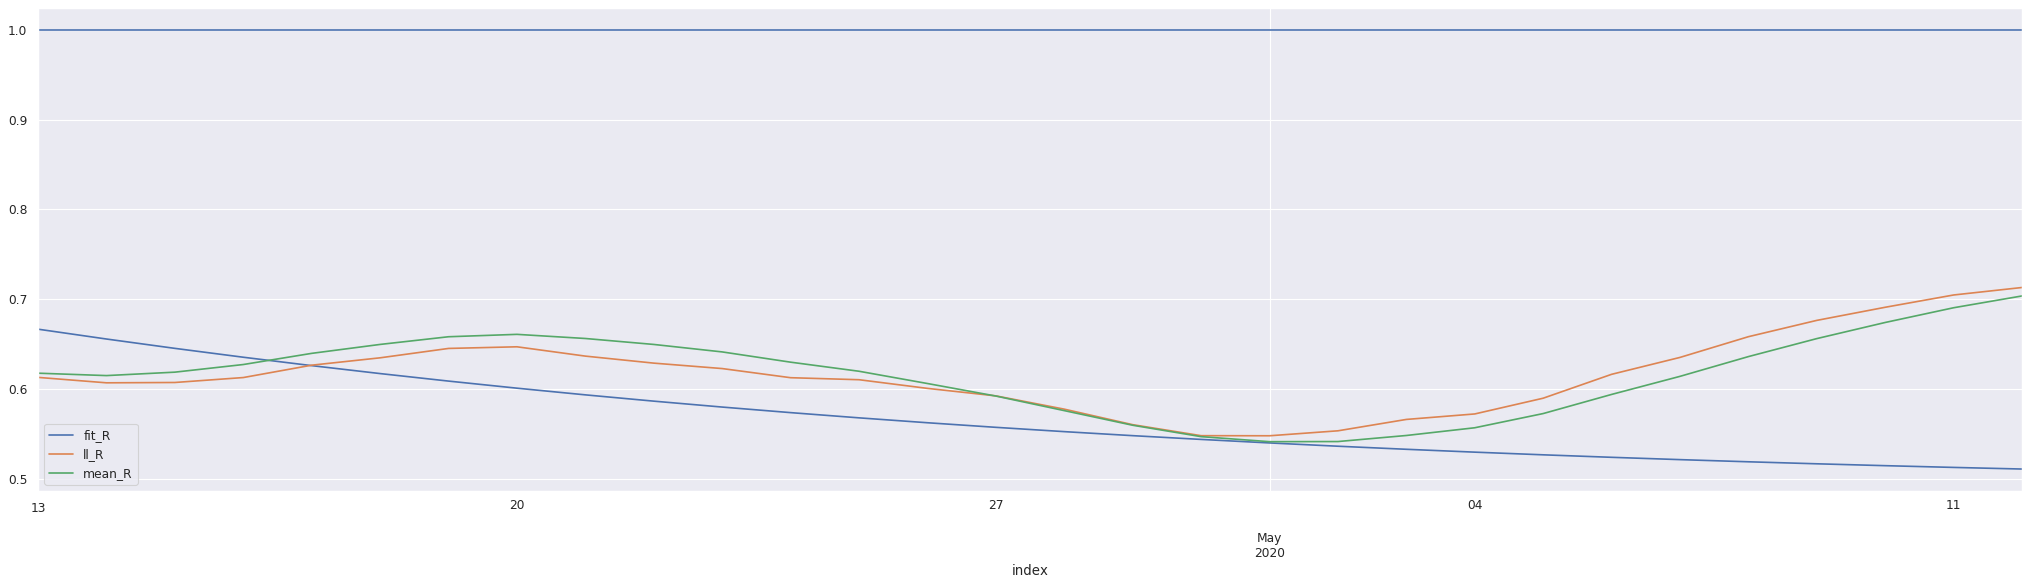

In [17]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_bavaria.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [18]:
df = covid19.get_rki_df(state='Nordrhein-Westfalen')
cbr_nrw = covid19.CasesByRegion('NRW', df=df)
cbr_nrw.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-10,35435,31522,1489,86,0,1
2020-05-11,35593,31522,1490,158,0,1
2020-05-12,35722,31522,1490,129,0,0
2020-05-13,35852,31522,1490,130,0,0
2020-05-14,35951,31521,1490,99,-1,0


In [19]:
einwohner_nrw      = 17932651.0
prozent_nrw        = einwohner_nrw / einwohner_deutschland

nrw_new_confirmed_threshold = (100.0 * prozent_nrw) // 1 + 1
nrw_new_confirmed_threshold

22.0

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric: seor: 99.86229236583544, max asymptotic: 37265.0138721185; growth-rate: 0.003, date:2020-06-12 00:00:00, projected value: 19.765391975137568


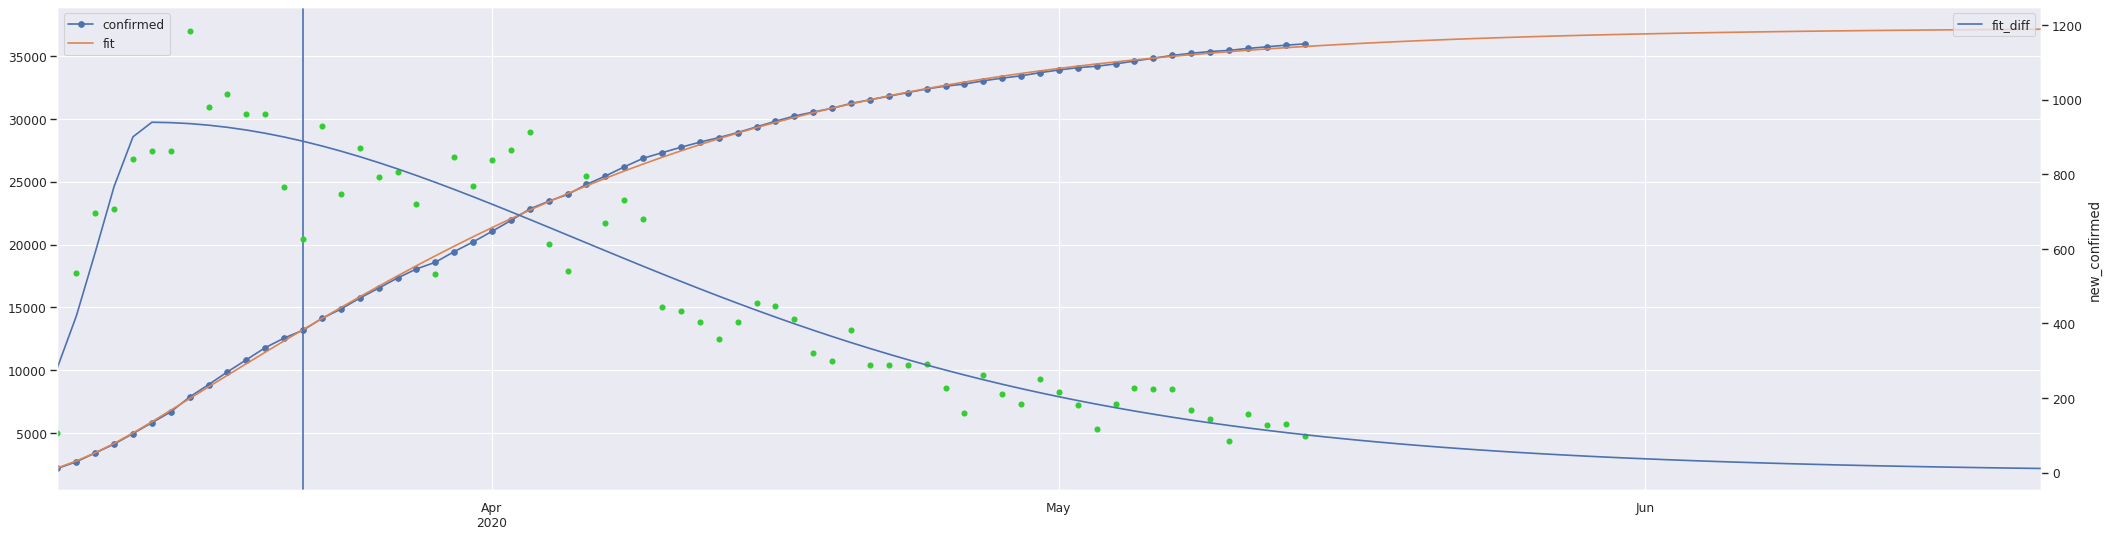

In [20]:
cbr_nrw.fit(first_date=pd.to_datetime('2020-03-09'), new_confirmed_threshold=nrw_new_confirmed_threshold)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_nrw.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [21]:
cbr_nrw.calculate_R_estimates()
cbr_nrw.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-12,0.635,0.726,0.524,0.657,0.673


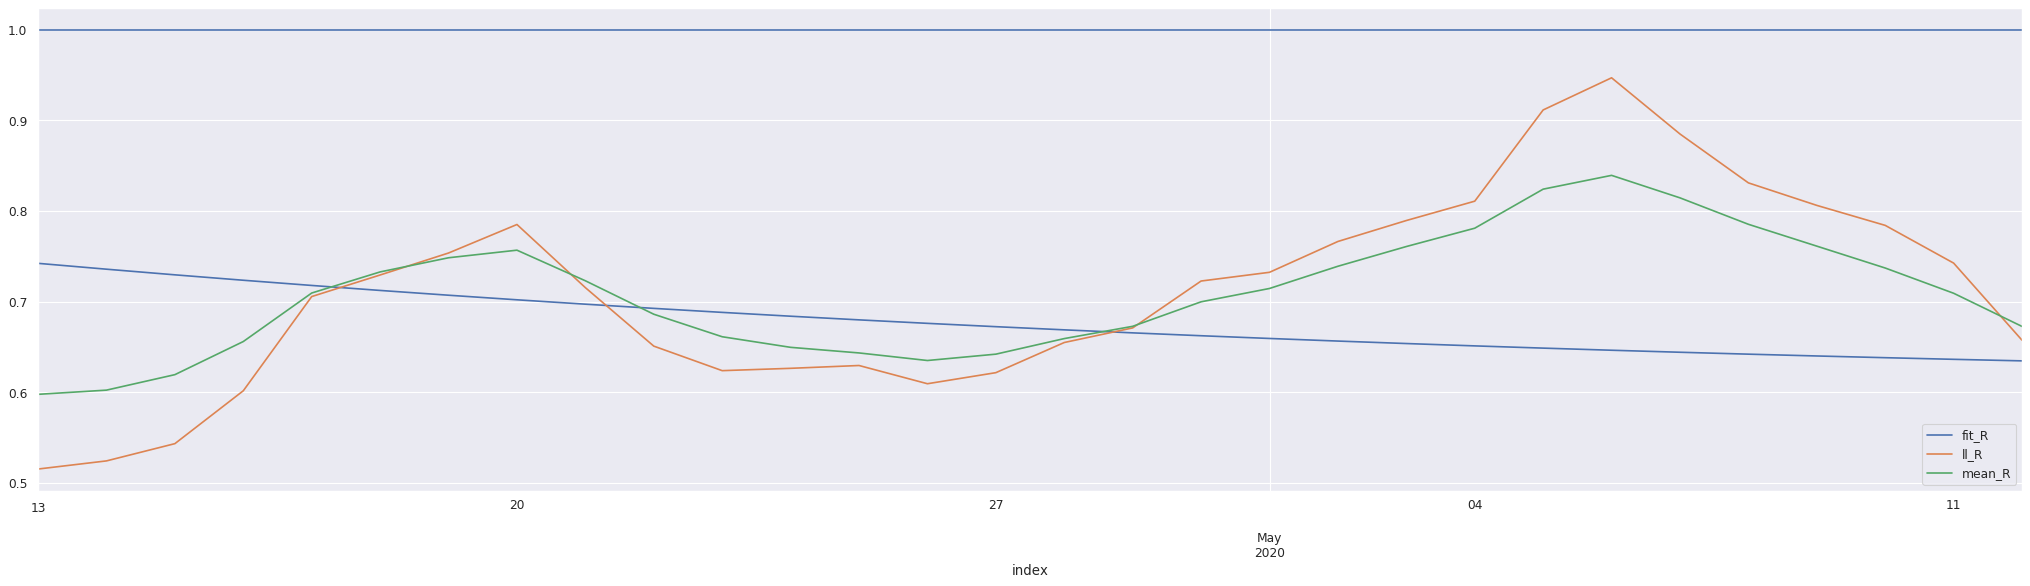

In [22]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_nrw.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [23]:
covid19.rki_data_df.Bundesland.unique()

array(['Schleswig-Holstein', 'Hamburg', 'Niedersachsen', 'Bremen', 'Nordrhein-Westfalen', 'Hessen', 'Rheinland-Pfalz', 'Baden-Württemberg', 'Bayern', 'Saarland', 'Berlin', 'Brandenburg', 'Mecklenburg-Vorpommern', 'Sachsen', 'Sachsen-Anhalt', 'Thüringen'], dtype=object)

In [24]:
df = covid19.get_rki_df(state='Baden-W')
cbr_bw = covid19.CasesByRegion('BW', df=df)
cbr_bw.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-10,33584,29723,1627,46,0,0
2020-05-11,33656,29723,1627,72,0,0
2020-05-12,33716,29723,1628,60,0,1
2020-05-13,33798,29723,1628,82,0,0
2020-05-14,33838,29723,1628,40,0,0


In [25]:
einwohner_bw      = 11069533.0
prozent_bw        = einwohner_bw / einwohner_deutschland

bw_new_confirmed_threshold = (100.0 * prozent_bw) // 1 + 1
bw_new_confirmed_threshold

14.0

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric: seor: 91.17662628299837, max asymptotic: 34941.67145374026; growth-rate: 0.002, date:2020-06-09 00:00:00, projected value: 13.03441986415542


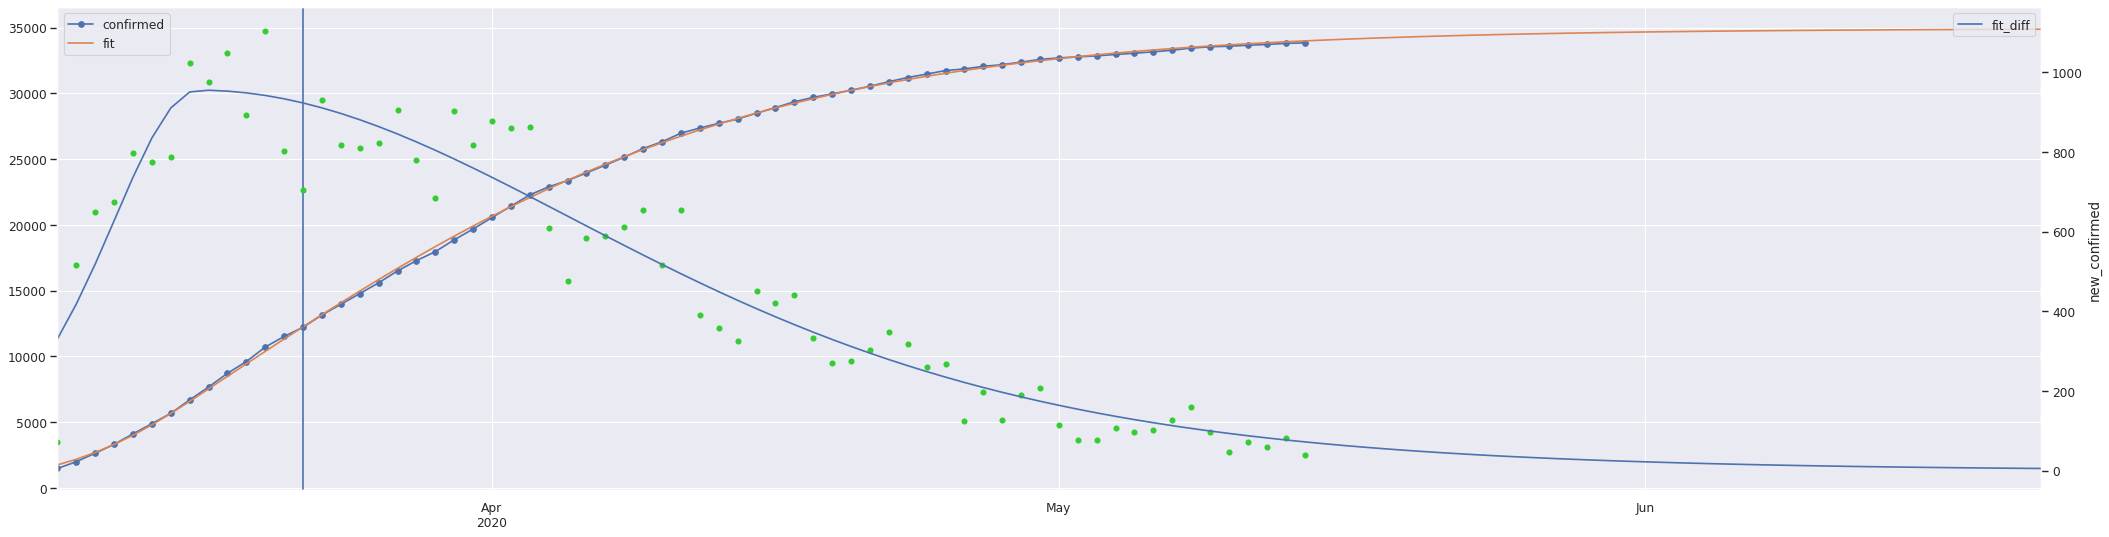

In [26]:
cbr_bw.fit(first_date=pd.to_datetime('2020-03-09'), new_confirmed_threshold=bw_new_confirmed_threshold)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_bw.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [27]:
cbr_bw.calculate_R_estimates()
cbr_bw.R().round(3)

,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-12,0.571,0.698,0.629,0.67,0.646


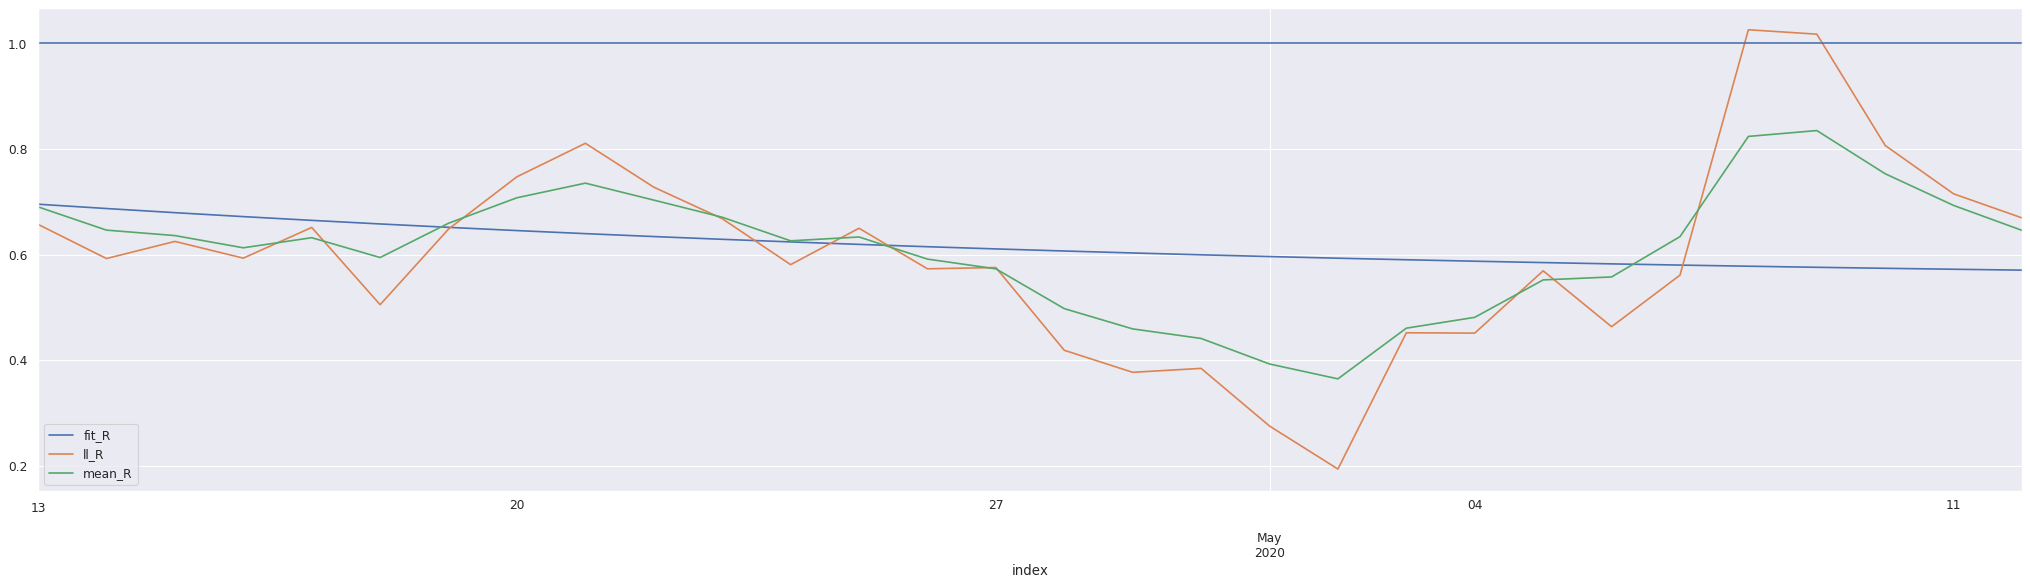

In [28]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_bw.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [29]:
df = covid19.get_rki_df(county='LK Traunstein')
cbr_traunstein = covid19.CasesByRegion('LK Traunstein', df=df)
cbr_traunstein.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-10,1264,1071,83,0,0,0
2020-05-11,1265,1071,83,1,0,0
2020-05-12,1265,1071,83,0,0,0
2020-05-13,1266,1071,83,1,0,0
2020-05-14,1266,1071,83,0,0,0


In [30]:
tage_inzidenz = 10

In [31]:
# https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/Administrativ/04-kreise.html
einwohner_lk_traunstein = 177089
einwohner_sk_regensburg = 152610
einwohner_lk_regensburg = 193572

In [32]:
tage_inzidenz_lk_traunstein = cbr_traunstein.df['new_confirmed'][-tage_inzidenz:].sum() 
round(tage_inzidenz_lk_traunstein,1), round(tage_inzidenz_lk_traunstein / einwohner_lk_traunstein / tage_inzidenz  * 100000,1), round(tage_inzidenz_lk_traunstein / einwohner_lk_traunstein / tage_inzidenz  * 100000 * 7,1)

(38, 2.1, 15.0)

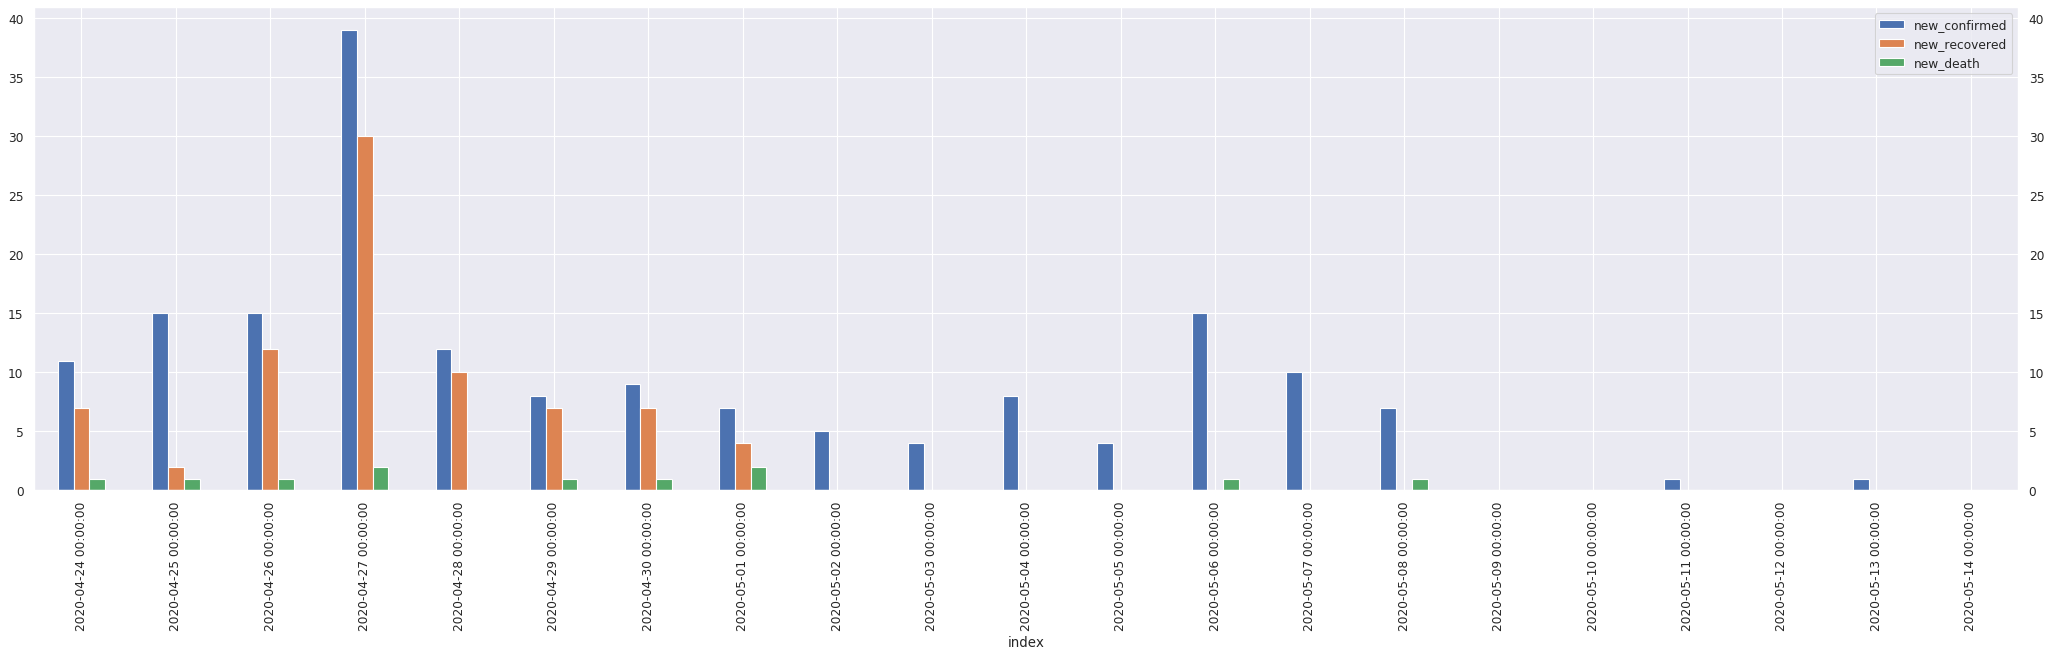

In [33]:
cbr_traunstein.plot_daily_stats()

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric: seor: 7.514303738240633, max asymptotic: 1422.6161284182076; growth-rate: 0.005, date:2020-06-22 00:00:00, projected value: 0.7010404360966974


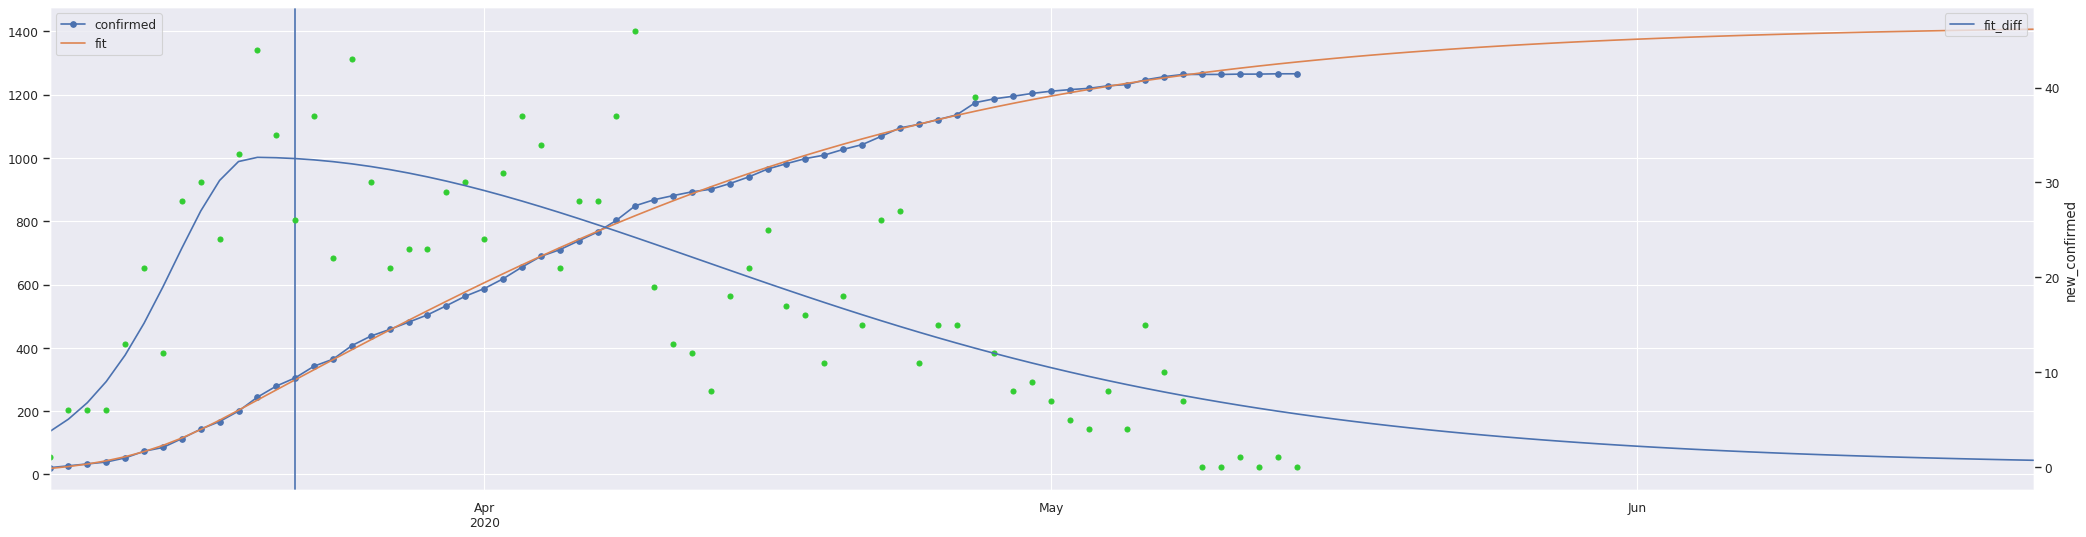

In [34]:
cbr_traunstein.fit(first_date=pd.to_datetime('2020-03-09'))
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_traunstein.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [35]:
cbr_traunstein.calculate_R_estimates()
cbr_traunstein.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-12,0.668,0.599,0.146,0.486,0.584


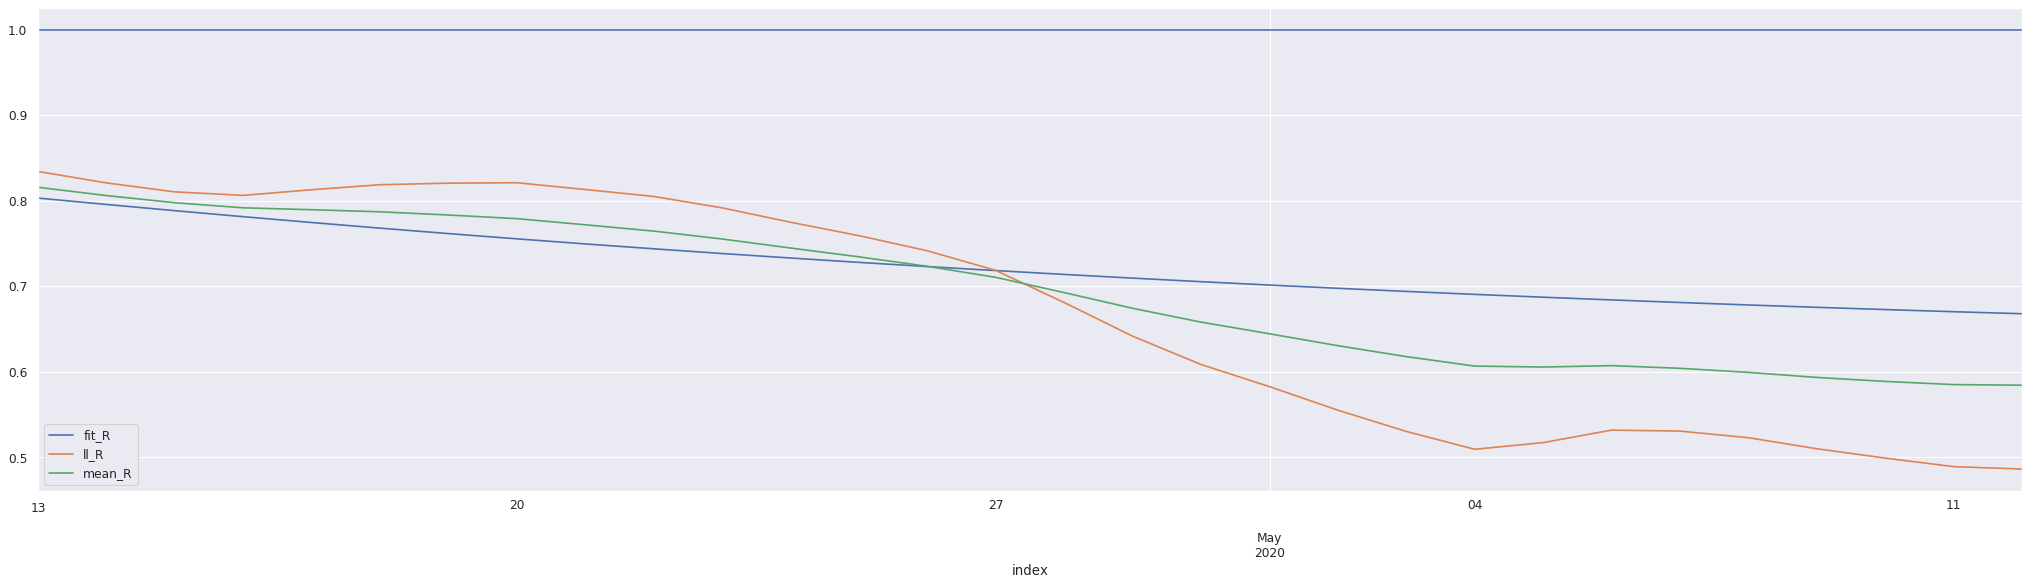

In [36]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_traunstein.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [37]:
df = covid19.get_rki_df(county='SK Regensburg')
cbr_sk_regensburg = covid19.CasesByRegion('SK Regensburg', df=df)
cbr_sk_regensburg.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-10,477,434,9,0,0,0
2020-05-11,479,434,9,2,0,0
2020-05-12,479,434,9,0,0,0
2020-05-13,481,434,9,2,0,0
2020-05-14,483,434,9,2,0,0


In [38]:
tage_inzidenz_sk_regensburg = cbr_sk_regensburg.df['new_confirmed'][-tage_inzidenz:].sum()
round(tage_inzidenz_sk_regensburg,1), round(tage_inzidenz_sk_regensburg / einwohner_sk_regensburg / tage_inzidenz * 100000, 1), round(tage_inzidenz_sk_regensburg / einwohner_sk_regensburg / tage_inzidenz * 100000 * 7, 1)

(11, 0.7, 5.0)

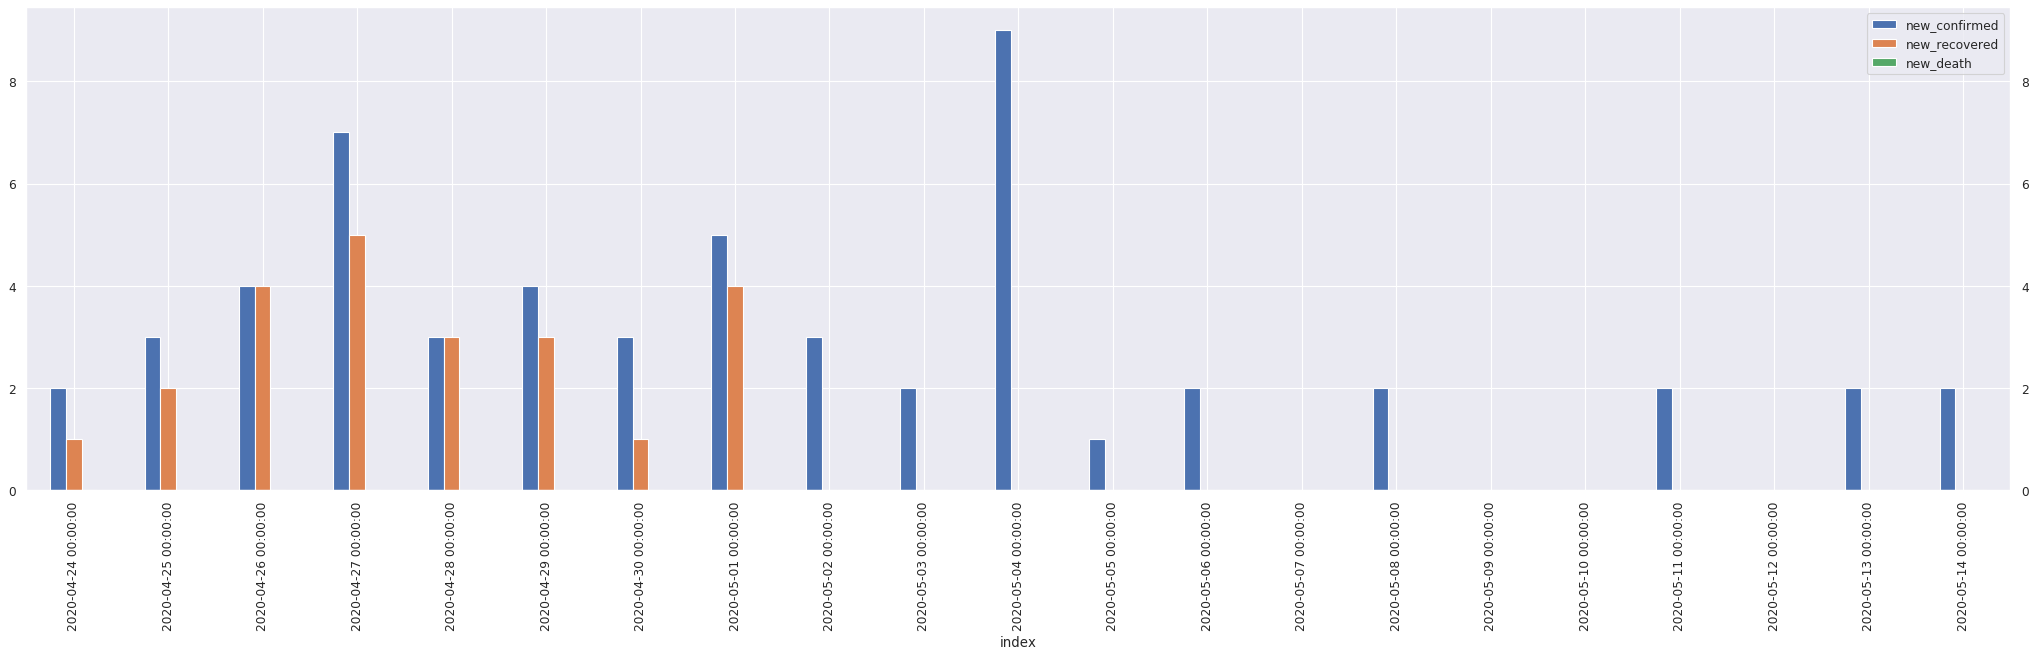

In [39]:
cbr_sk_regensburg.plot_daily_stats()

In [40]:
df = covid19.get_rki_df(county='LK Regensburg')
cbr_lk_regensburg = covid19.CasesByRegion('LK Regensburg', df=df)
cbr_lk_regensburg.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-10,443,410,14,0,0,0
2020-05-11,444,410,14,1,0,0
2020-05-12,444,410,14,0,0,0
2020-05-13,444,410,14,0,0,0
2020-05-14,447,410,14,3,0,0


In [41]:
tage_inzidenz_lk_regensburg = cbr_lk_regensburg.df['new_confirmed'][-tage_inzidenz:].sum()
tage_inzidenz_lk_regensburg, round(tage_inzidenz_lk_regensburg / einwohner_lk_regensburg / tage_inzidenz * 100000, 1), round(tage_inzidenz_lk_regensburg / einwohner_lk_regensburg / tage_inzidenz * 100000 * 7, 1)

(11, 0.6, 4.0)

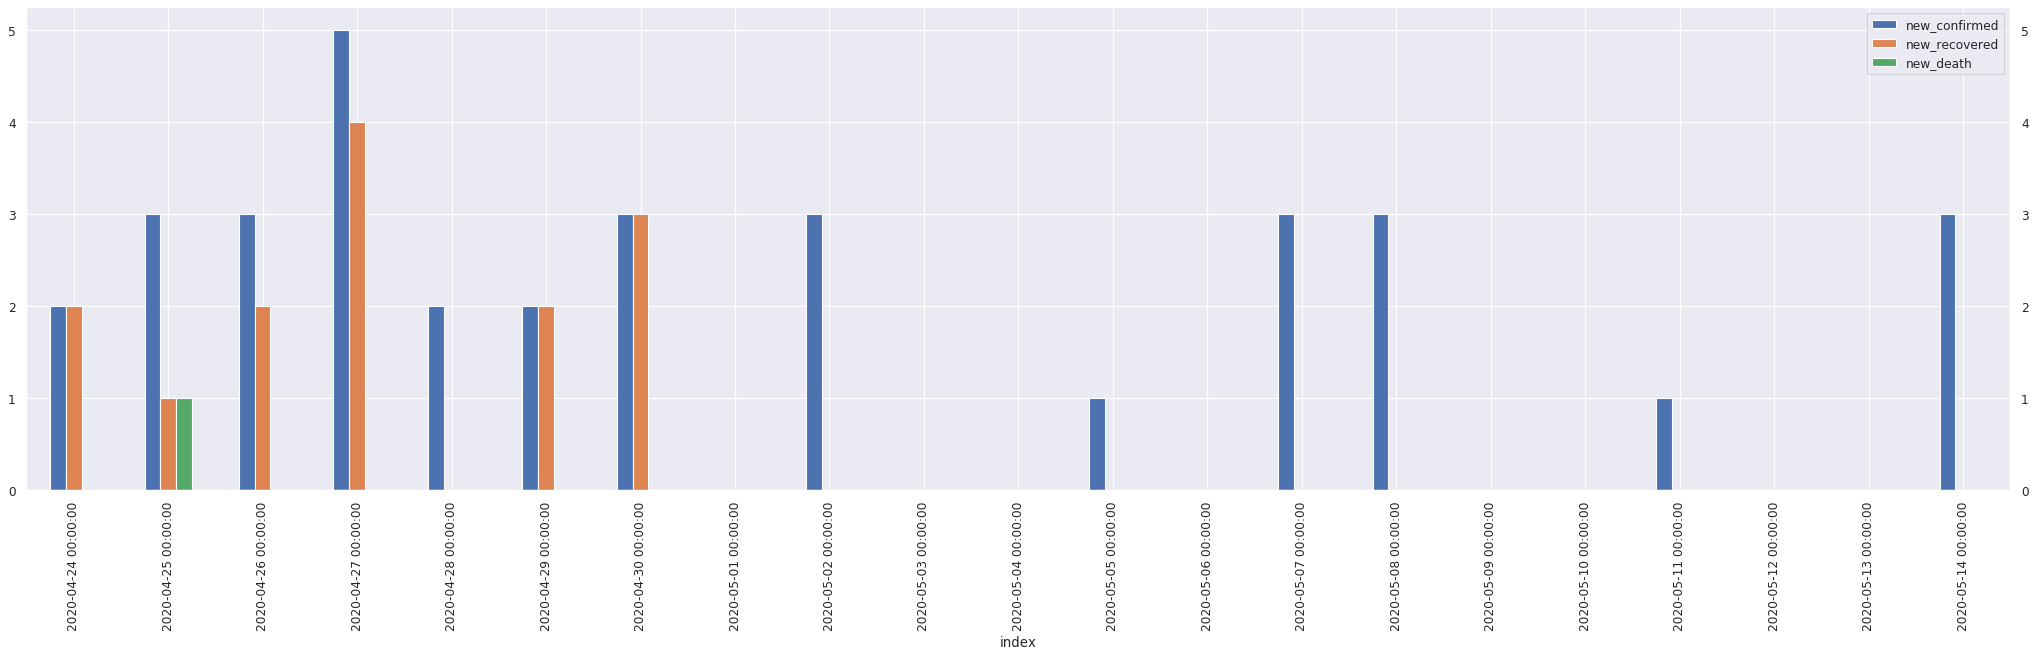

In [42]:
cbr_lk_regensburg.plot_daily_stats()

In [43]:
# --------------------------------------------------------------------------------------------------------------------------------



# --------------------------------------------------------------------------------------------------------------------------------

In [44]:
df = covid19.get_rki_df(time_anchor_column_name='Meldedatum')
cbr_germany2 = covid19.CasesByRegion('Germany', df=df)
cbr_germany2.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-10,170362,151445,7444,342,25,9
2020-05-11,171033,151487,7510,671,42,66
2020-05-12,171865,151534,7633,832,47,123
2020-05-13,172688,151552,7732,823,18,99
2020-05-14,173073,151560,7812,385,8,80


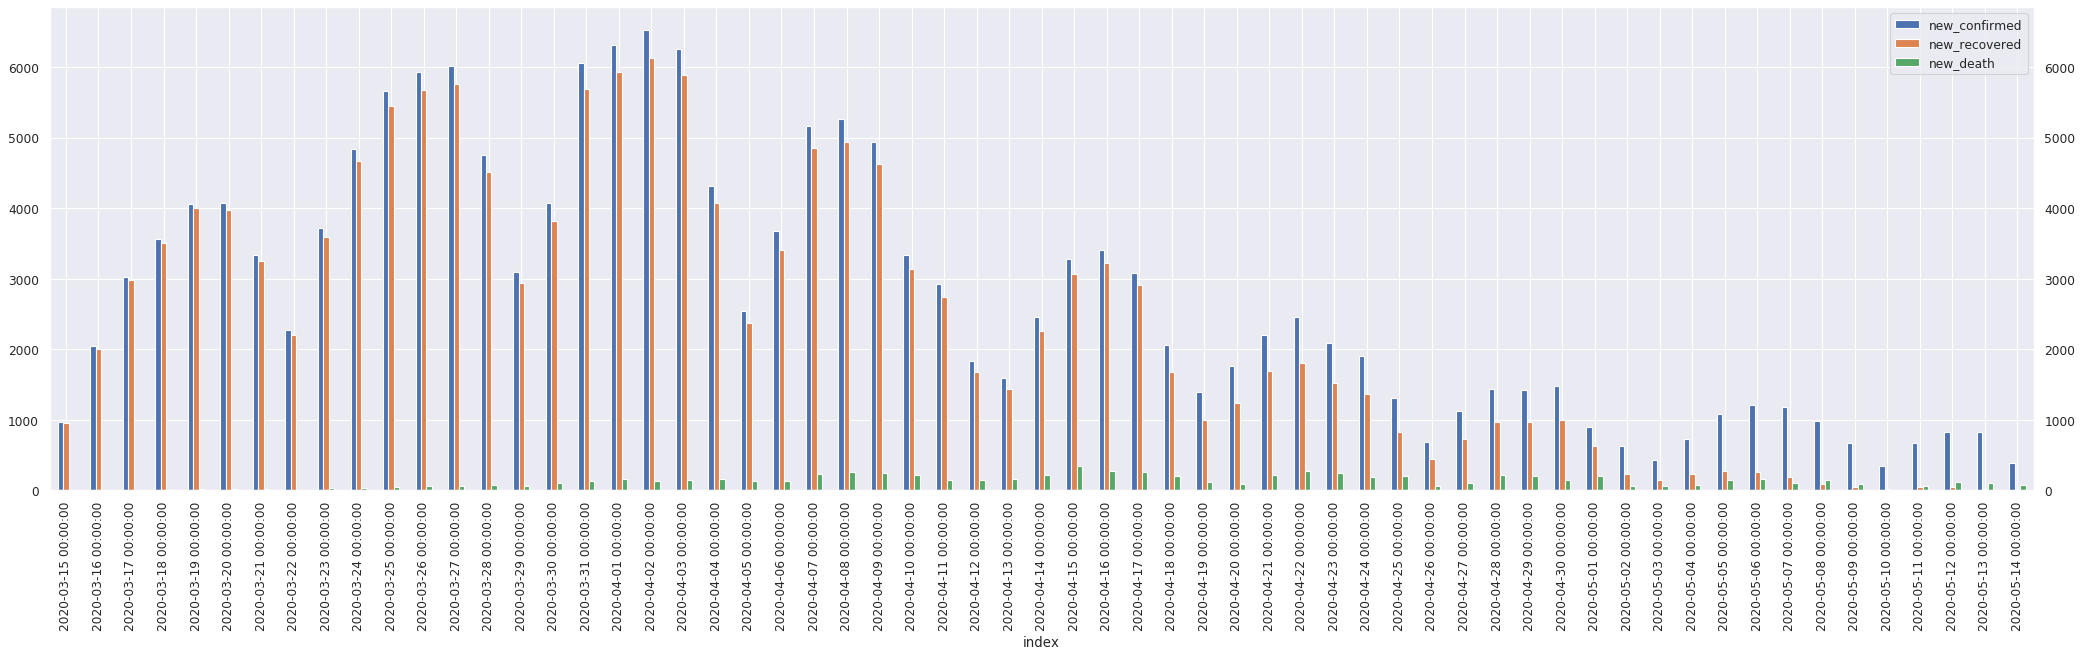

In [45]:
cbr_germany2.plot_daily_stats(days=60)

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric+linear: seor: 822.1051709258568; growth-rate: 0.004, date:2020-06-22 00:00:00, projected value: 578.4351096076617


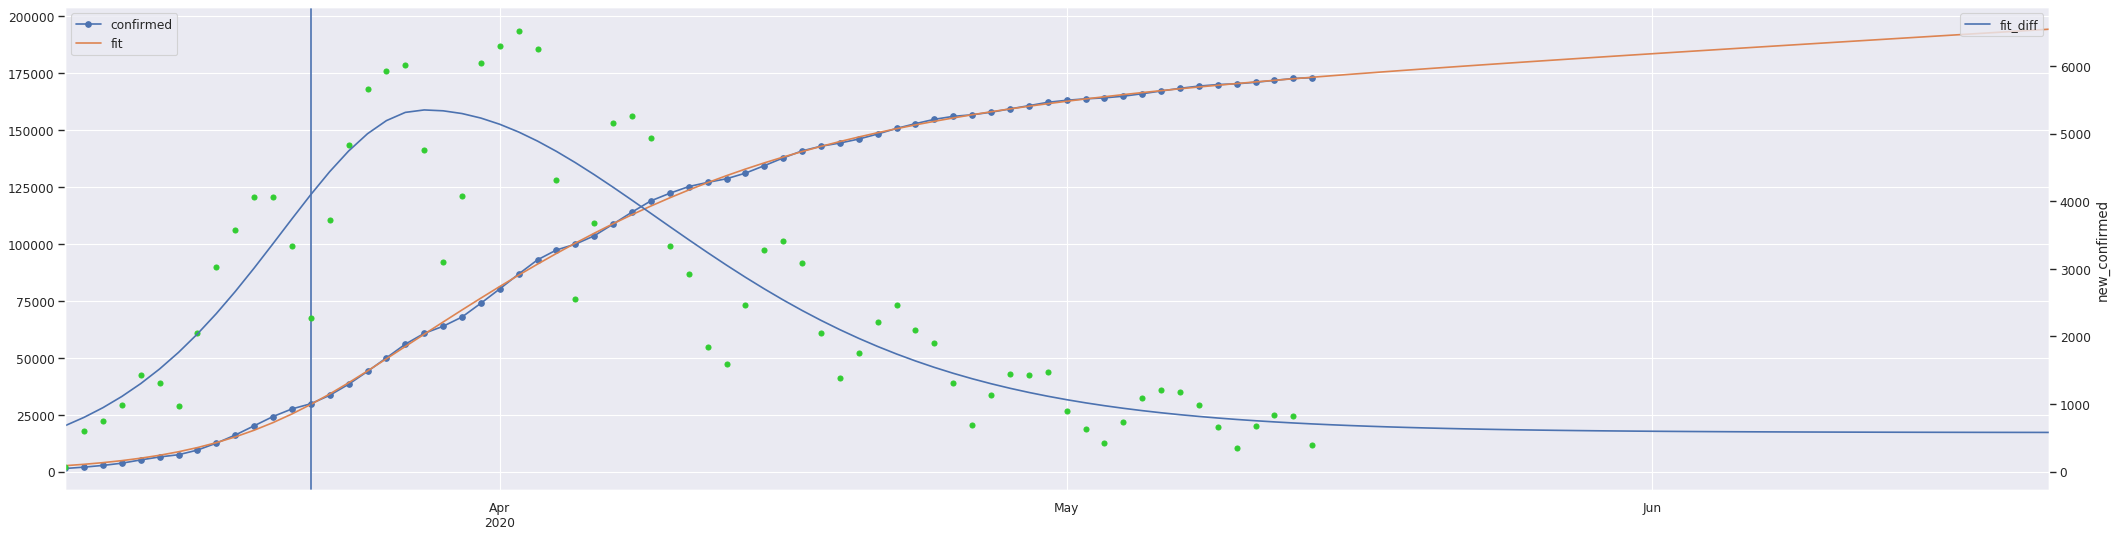

In [46]:
cbr_germany2.fit(first_date=pd.to_datetime('2020-03-09'))
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany2.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [47]:
cbr_germany2.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,5352.280724


In [48]:
cbr_germany2.calculate_R_estimates()
cbr_germany2.R().round(3)

,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-12,0.796,0.934,0.796,0.829,0.853


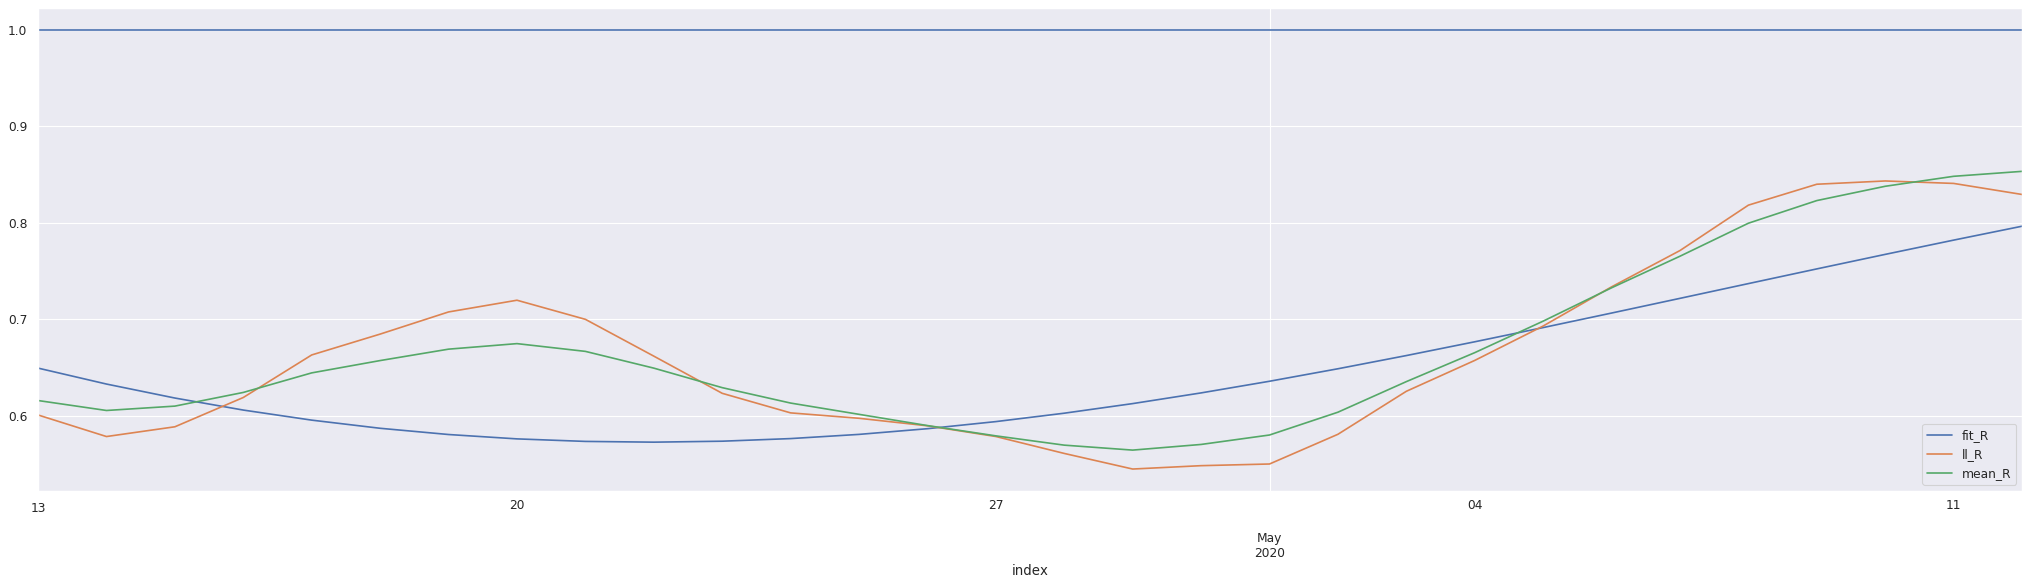

In [49]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany2.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [50]:
cbr_germany3 = covid19.CasesByRegion('Germany')
cbr_germany3.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-10,169876,144575,7444,460,1205,9
2020-05-11,170418,145617,7510,542,1042,66
2020-05-12,171150,147298,7633,732,1681,123
2020-05-13,172094,148700,7732,944,1402,99
2020-05-14,172961,150300,7812,867,1600,80


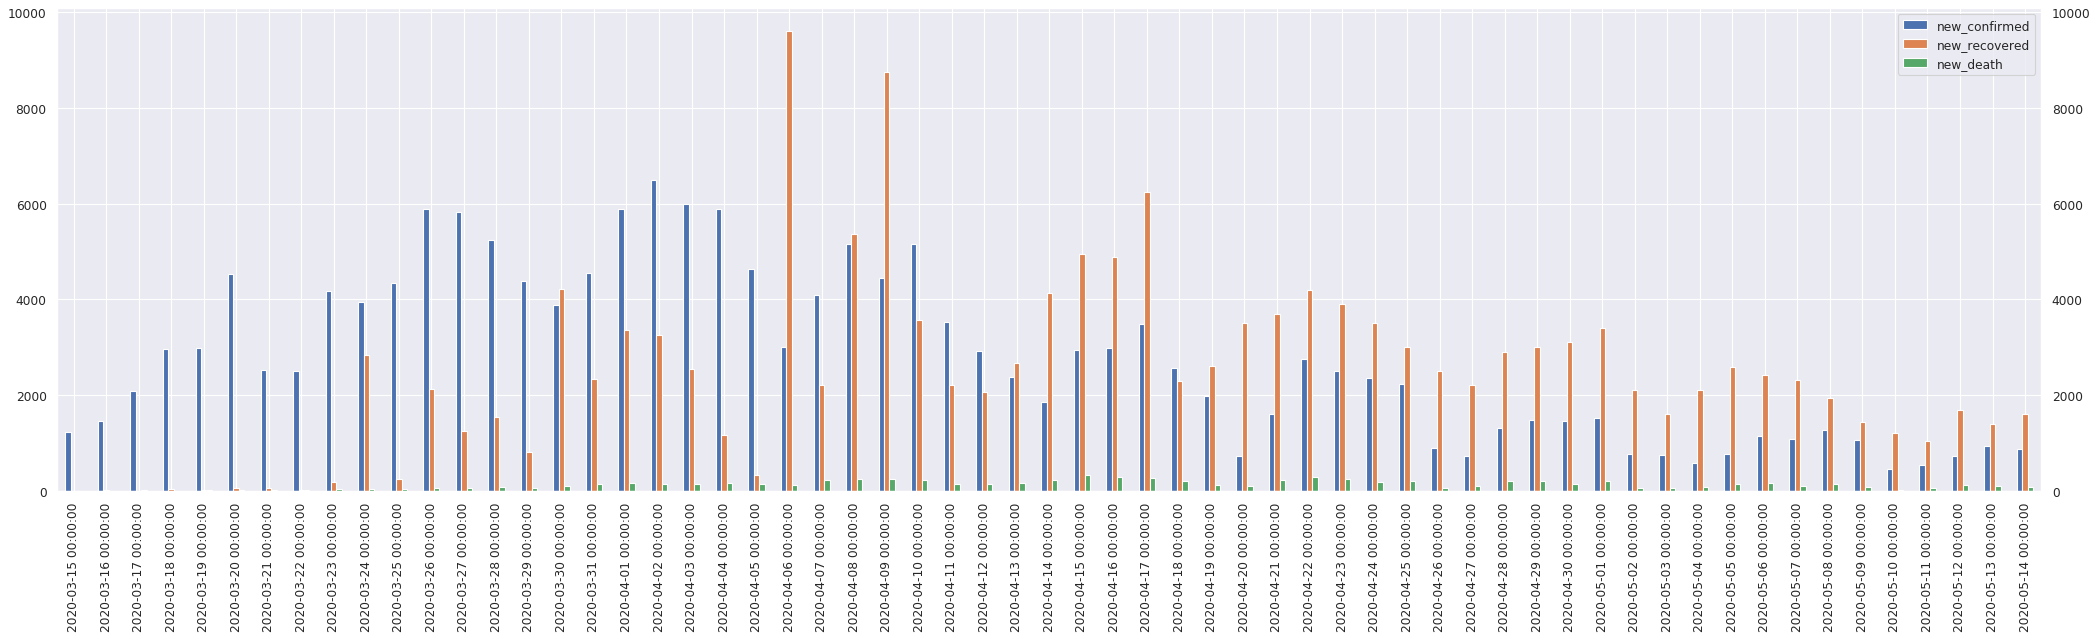

In [51]:
cbr_germany3.plot_daily_stats(days=60)

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric+linear: seor: 712.922445932873; growth-rate: 0.004, date:2020-06-22 00:00:00, projected value: 603.3644375334239


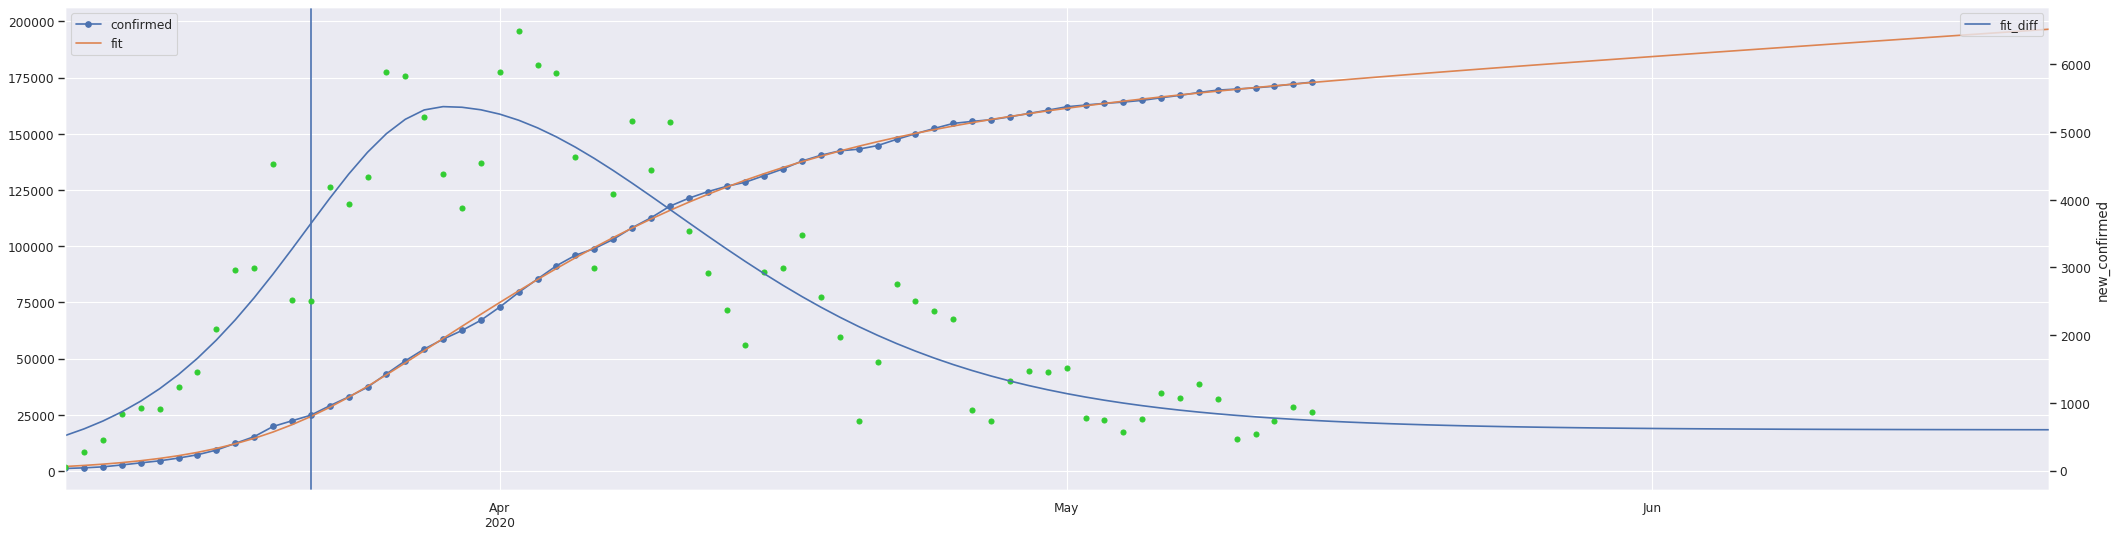

In [52]:
cbr_germany3.fit(first_date=pd.to_datetime('2020-03-09'))
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany3.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [53]:
cbr_germany3.calculate_R_estimates()
cbr_germany3.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-05-12,0.788,0.961,0.969,0.817,0.855


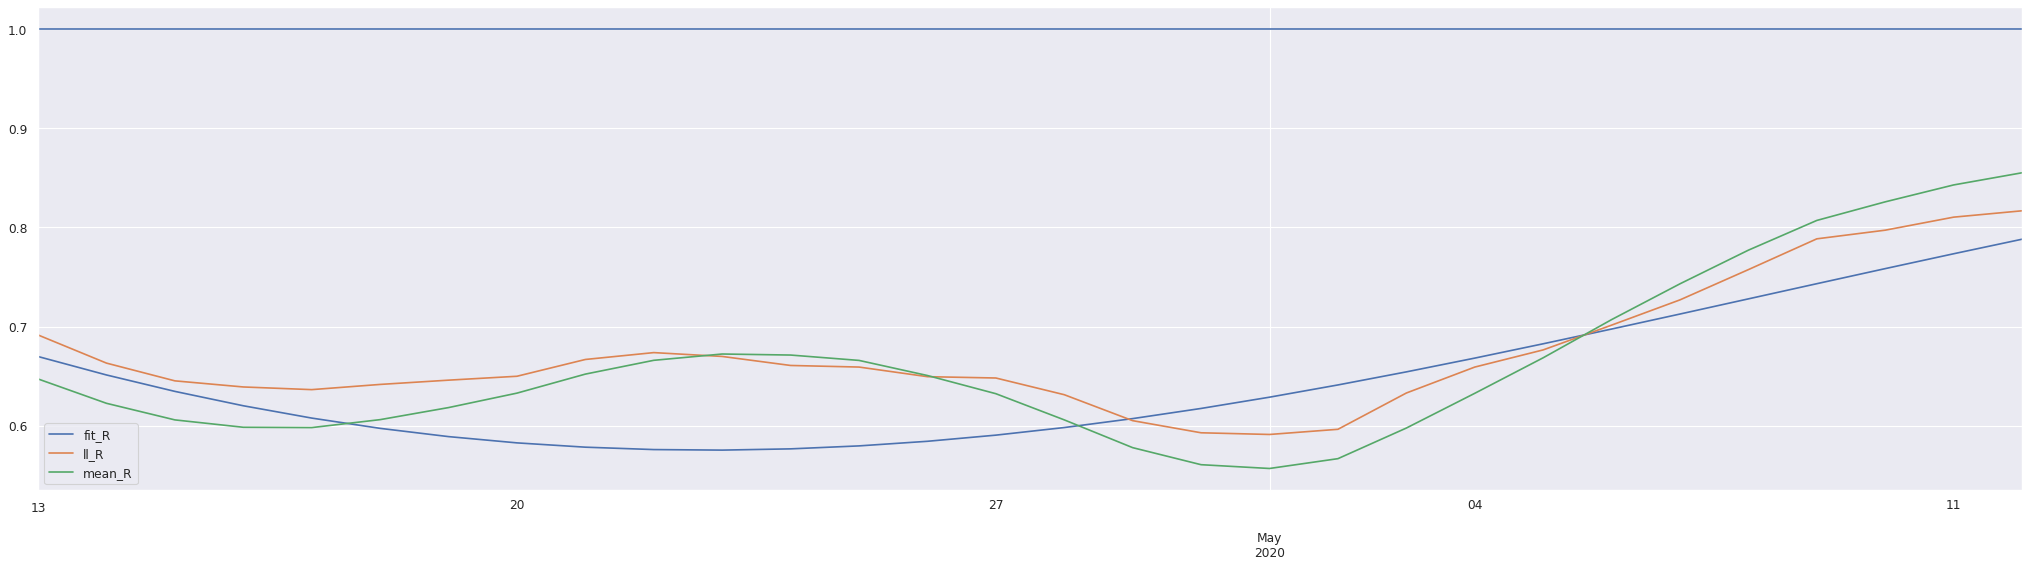

In [54]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany3.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [55]:
import requests

In [56]:
# https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/Nowcasting.html
# rki_nowcasting_data_url = 'https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/Nowcasting_Zahlen.xlsx'
rki_nowcasting_data_url = 'https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/Nowcasting_Zahlen.xlsx?__blob=publicationFile'

r = requests.get(rki_nowcasting_data_url, allow_redirects=True)  # to get content after redirection
# r.url, r.content
xd = pd.ExcelFile(r.content)
rki_nowcasting_df_ = xd.parse(xd.sheet_names[-1])
rki_nowcasting_df_.to_excel("rki_nowcasting_data.xlsx") 
rki_nowcasting_df_.tail()

,Datum des Erkrankungsbeginns,Punktschätzer der Anzahl Neuerkrankungen (ohne Glättung),Untere Grenze des 95%-Prädiktionsintervalls der Anzahl Neuerkrankungen (ohne Glättung),Obere Grenze des 95%-Prädiktionsintervalls der Anzahl Neuerkrankungen (ohne Glättung),Punktschätzer der Anzahl Neuerkrankungen,Untere Grenze des 95%-Prädiktionsintervalls der Anzahl Neuerkrankungen,Obere Grenze des 95%-Prädiktionsintervalls der Anzahl Neuerkrankungen,Punktschätzer der Reproduktionszahl R,Untere Grenze des 95%-Prädiktionsintervalls der Reproduktionszahl R,Obere Grenze des 95%-Prädiktionsintervalls der Reproduktionszahl R,Punktschätzer des 7-Tage-R Wertes,Untere Grenze des 95%-Prädiktionsintervalls des 7-Tage-R Wertes,Obere Grenze des 95%-Prädiktionsintervalls des 7-Tage-R Wertes
65,2020-05-06,823.81,657.38,980.38,864.40,732.11,993.22,1.020,0.939,1.114,0.919,0.870,0.970
66,2020-05-07,751.90,584.08,925.34,847.73,698.06,993.02,1.024,0.927,1.125,0.929,0.874,0.987
67,2020-05-08,679.77,507.17,881.52,784.84,628.51,948.90,0.951,0.832,1.088,0.913,0.852,0.980
68,2020-05-09,611.34,409.82,816.21,716.71,539.61,900.86,0.846,0.726,0.968,0.880,0.812,0.951
69,2020-05-10,556.54,320.30,840.03,649.89,455.34,865.77,0.753,0.606,0.877,NaN,NaN,NaN


In [57]:
rki_nowcasting_df = rki_nowcasting_df_[['Datum des Erkrankungsbeginns', 'Punktschätzer der Anzahl Neuerkrankungen (ohne Glättung)', 'Punktschätzer der Anzahl Neuerkrankungen']].copy()
rki_nowcasting_df.columns = ['index', 'new_confirmed', 'new_confirmed_']
rki_nowcasting_df['index'] = pd.to_datetime(rki_nowcasting_df['index'])
rki_nowcasting_df = rki_nowcasting_df.set_index('index')

last_date = rki_nowcasting_df.index[-1] + pd.DateOffset(days=1)
last_value = cbr_germany.df['confirmed'].loc[last_date]
# last_date, last_value

ldf = pd.DataFrame(index=rki_nowcasting_df.index)
ldf['confirmed'] = last_value - rki_nowcasting_df['new_confirmed'].values[::-1].cumsum()[::-1]
ldf.loc[last_date] = [last_value]
ldf['recovered'] = 0
ldf['death']     = 0
ldf['new_confirmed'] = covid19.discrete_diff(ldf['confirmed'])
ldf['new_recovered'] = covid19.discrete_diff(ldf['recovered'])
ldf['new_death']     = covid19.discrete_diff(ldf['death'])

rki_nowcasting_df = ldf.copy()

cbr_germany4 = covid19.CasesByRegion('Germany', df=rki_nowcasting_df)
cbr_germany4.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-07,169225.45,0,0,823.81,0.0,0.0
2020-05-08,169977.35,0,0,751.90,0.0,0.0
2020-05-09,170657.12,0,0,679.77,0.0,0.0
2020-05-10,171268.46,0,0,611.34,0.0,0.0
2020-05-11,171825.00,0,0,556.54,0.0,0.0


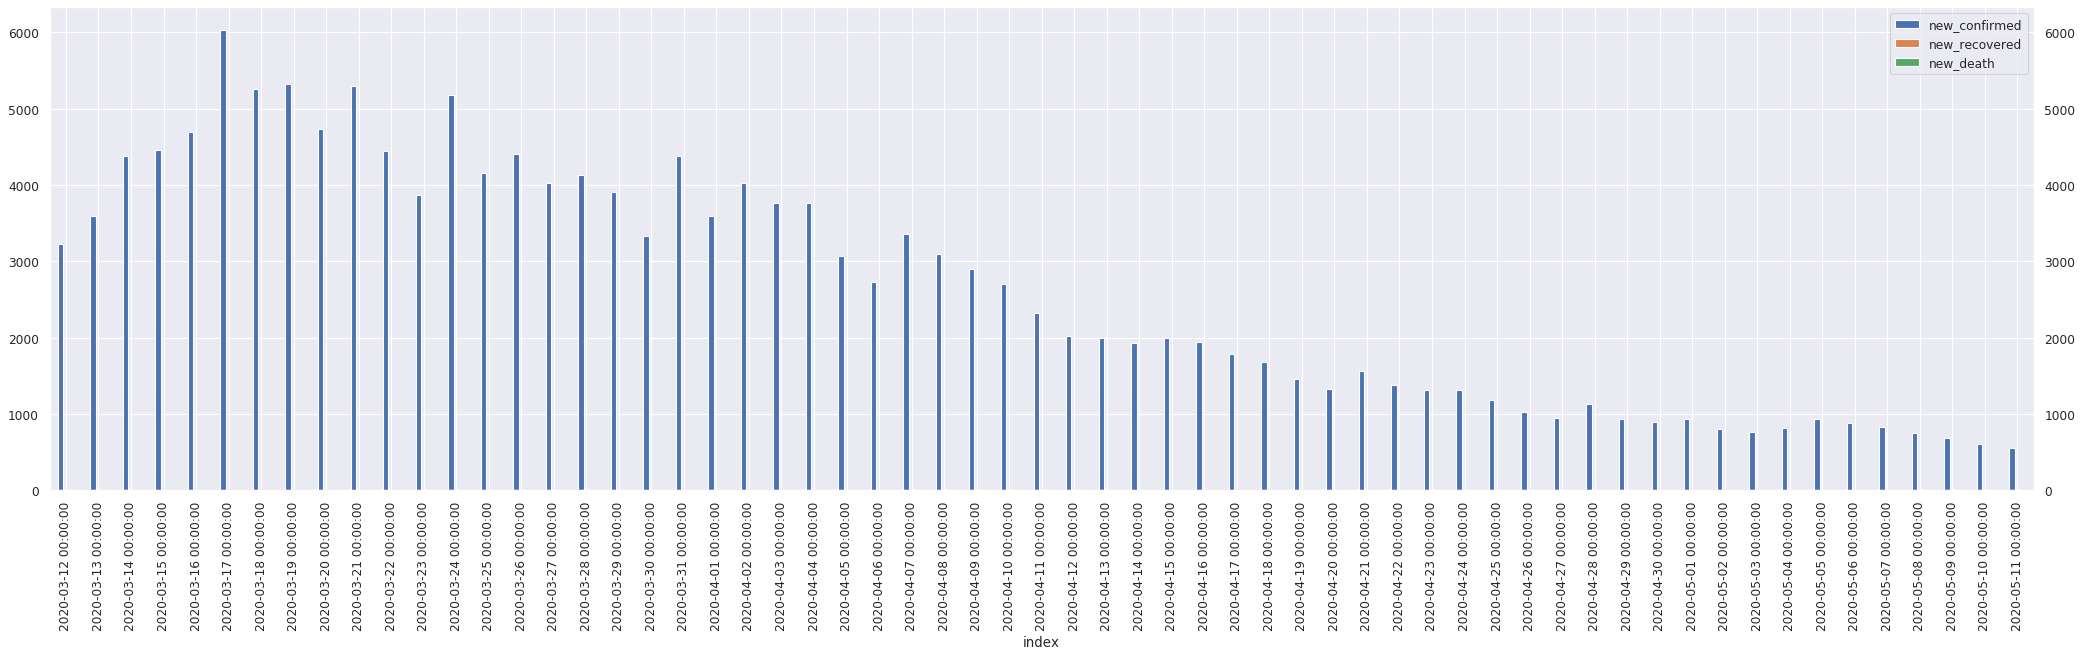

In [58]:
cbr_germany4.plot_daily_stats(days=60)

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric+linear: seor: 331.8071095208611; growth-rate: 0.004, date:2020-06-19 00:00:00, projected value: 326.8754713154717


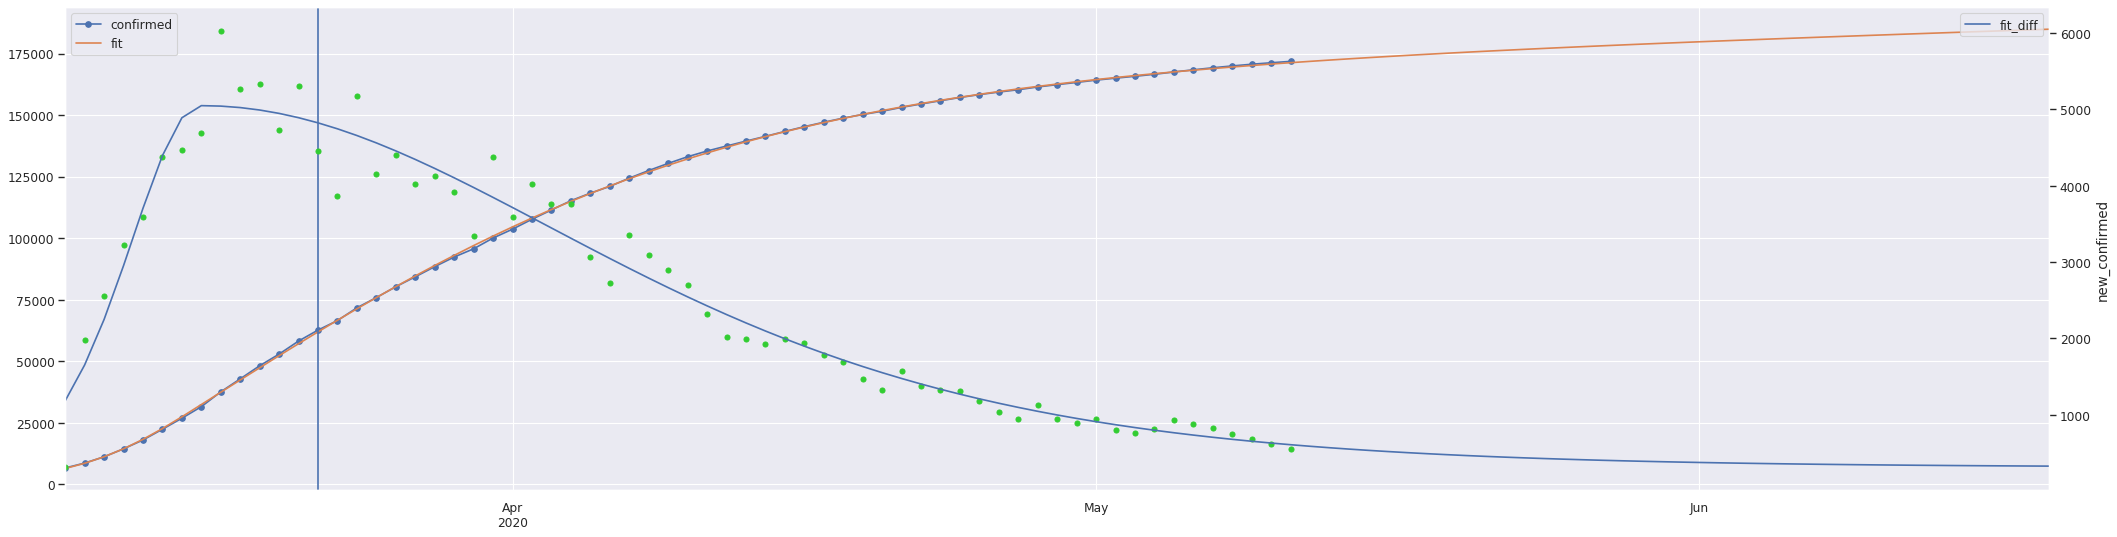

In [59]:
cbr_germany4.fit(first_date=pd.to_datetime('2020-03-09'))
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany4.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [60]:
cbr_germany4.calculate_R_estimates()
cbr_germany4.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-09,0.718,0.881,0.843,0.857,0.819


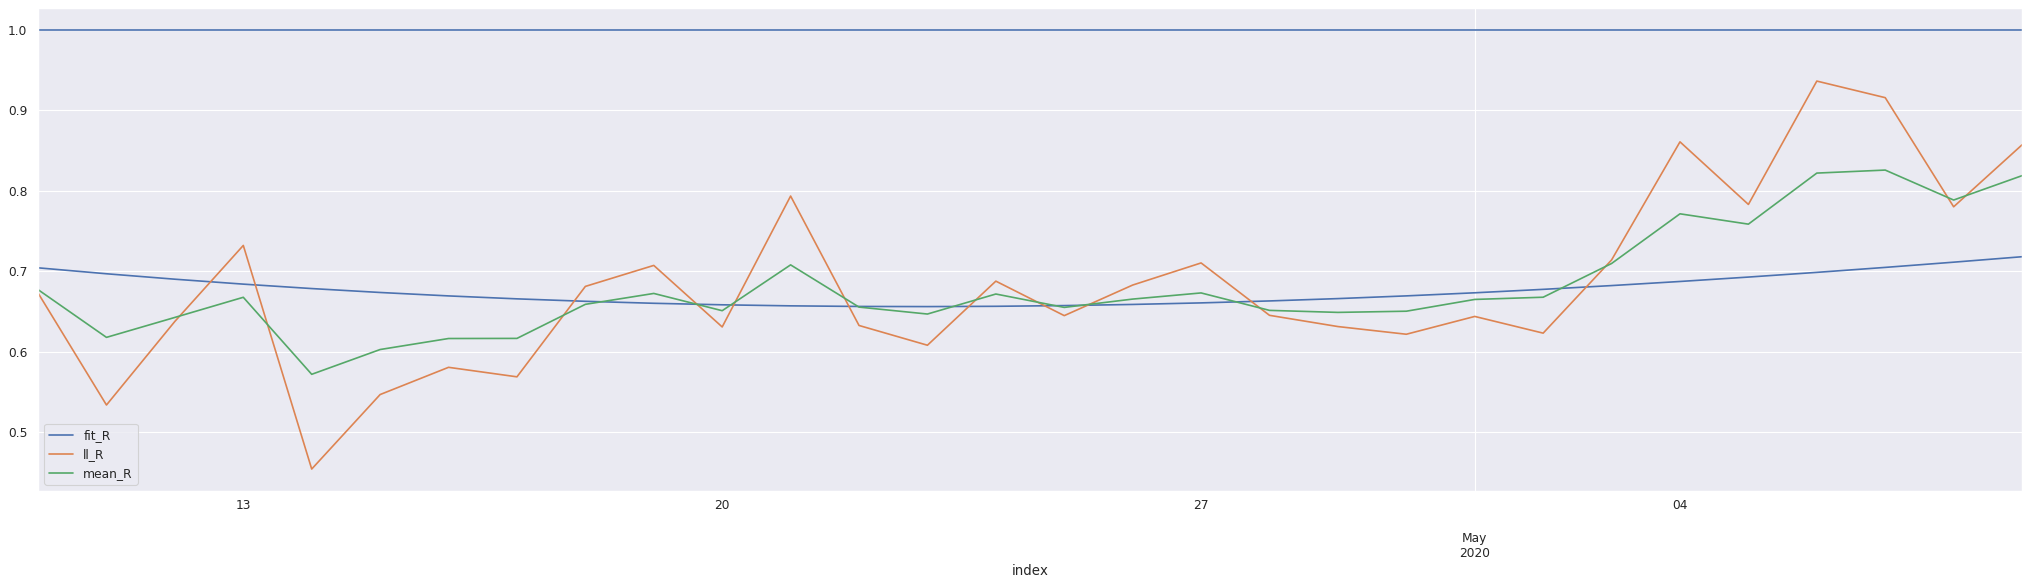

In [61]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany4.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [62]:
ldf = cbr_germany.df.loc[cbr_germany4.df.index, ['new_confirmed']]
ldf['new_confirmed_nc'] = cbr_germany4.df['new_confirmed']
ldf['delta'] = ldf['new_confirmed_nc'] - ldf['new_confirmed']
ldf = ldf.astype(np.int)
ldf.iloc[-30:]

,new_confirmed,new_confirmed_nc,delta
index,,,
2020-04-12,1908,2023,115
2020-04-13,1771,1998,227
2020-04-14,2091,1926,-164
2020-04-15,2268,1993,-274
2020-04-16,2234,1945,-288
2020-04-17,2275,1786,-488
2020-04-18,1648,1687,39
2020-04-19,1331,1464,133
2020-04-20,1661,1323,-337
